# IMPORTS

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
import plotly.express as px
from scipy.stats import norm
import scipy.stats as st
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

# READING DATA

In [ ]:
train_df= pd.read_csv("/content/drive/MyDrive/training_data.csv")
train = train_df.copy()
test_df = pd.read_csv("/content/drive/MyDrive/prediction_template.csv")
test = test_df.copy()
train_df.head()
# df.info()

Date Tenor       0.1       0.2  ...       1.6       1.7       1.8       1.9
0  1/5/2017    2M  0.468214  0.419251  ...  0.296172  0.309045  0.321260  0.332831
1  1/5/2017    3M  0.458471  0.412710  ...  0.287647  0.298654  0.309196  0.319254
2  1/5/2017    6M  0.410305  0.374189  ...  0.259726  0.266312  0.272831  0.279207
3  1/5/2017    9M  0.385267  0.354580  ...  0.245360  0.249397  0.253564  0.257773
4  1/5/2017    1Y  0.358986  0.333608  ...  0.232303  0.234052  0.236049  0.238213

[5 rows x 21 columns]

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13642 entries, 0 to 13641
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    13642 non-null  object 
 1   Tenor   13642 non-null  object 
 2   0.1     13642 non-null  float64
 3   0.2     13642 non-null  float64
 4   0.3     13642 non-null  float64
 5   0.4     13642 non-null  float64
 6   0.5     13642 non-null  float64
 7   0.6     13642 non-null  float64
 8   0.7     13642 non-null  float64
 9   0.8     13642 non-null  float64
 10  0.9     13642 non-null  float64
 11  1       13642 non-null  float64
 12  1.1     13642 non-null  float64
 13  1.2     13642 non-null  float64
 14  1.3     13642 non-null  float64
 15  1.4     13642 non-null  float64
 16  1.5     13642 non-null  float64
 17  1.6     13642 non-null  float64
 18  1.7     13642 non-null  float64
 19  1.8     13642 non-null  float64
 20  1.9     13642 non-null  float64
dtypes: float64(19), object(2)
memory us

# PREPROCESSING
* Change Date to python's datetime object.
* Change Tenure Scale to days.
* Adding 2 hours to each of common date (For analysising each record).
* Add Date to Index for time series Analysis.

In [ ]:

import re

train_df['Date'] = pd.to_datetime(train_df['Date'] , format = '%m/%d/%Y')

# using datetime to calculate time exact difference
train_df['End_Tenure_Date'] = train_df['Date'] + train_df["Tenor"].apply(lambda x: pd.DateOffset(years=int(''.join(x.split('Y')[:-1]))) if (x[-1]=='Y') else pd.DateOffset(months=int(''.join(x.split('M')[:-1]))))
train_df['Tenure'] = (train_df['End_Tenure_Date'] - train_df['Date']).dt.days

train_df.drop(['Tenor','End_Tenure_Date'],axis=1,inplace=True)

train_df.head()

Date       0.1       0.2  ...       1.8       1.9  Tenure
0 2017-01-05  0.468214  0.419251  ...  0.321260  0.332831      59
1 2017-01-05  0.458471  0.412710  ...  0.309196  0.319254      90
2 2017-01-05  0.410305  0.374189  ...  0.272831  0.279207     181
3 2017-01-05  0.385267  0.354580  ...  0.253564  0.257773     273
4 2017-01-05  0.358986  0.333608  ...  0.236049  0.238213     365

[5 rows x 21 columns]

In [ ]:
train_df['new_date'] = train_df.groupby(['Date']).cumcount()+1
train_df['new_date'] = pd.to_datetime(train_df['Date']  , format = '%m-%d-%Y') +train_df['new_date'].apply(lambda x: pd.DateOffset(hours=x+2))
train_df['new_date']

In [ ]:
train_df.index = train_df['new_date']

# EDA

## DISTRIBUTION

In [ ]:
fig = go.Figure()
columns = ['0.1', '0.2','1', '1.1', '1.2', '1.3', '1.9']
for i in columns:
    fig.add_trace(
        
        go.Histogram(x=train_df[i],
                     name=i
                )
    )

fig.update_layout(
    title='Distribution of IVs',
    yaxis_title='volatility',
    xaxis_title='Time Period'
)
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show(renderer="colab")


## Volatilities For Different Strike Prices

In [ ]:

import plotly.express as px


columns = ['0.1', '0.2','1', '1.1', '1.2', '1.3', '1.9']
fig = go.Figure()
for i in columns:
   fig.add_trace(go.Scatter(x=train_df['datetime'], y=train_df[i],name=i))



fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.update_layout(
    title='volatility For diff strike prices(moneyness)',
    yaxis_title='volatility',
    xaxis_title='Time Period'
)
fig.show(renderer='colab')


In [ ]:
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
def create_corr_plot(series, title=None,plot_pacf=False):
    corr_array = pacf(series.dropna(), alpha=0.05,nlags=40) if plot_pacf else acf(series.dropna(), alpha=0.05,nlags=40)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title=f'Partial Autocorrelation (PACF) FOr {title}' if plot_pacf else f'Autocorrelation (ACF) for {title}'
    fig.update_layout(title=title)
    fig.show(renderer='colab')


In [ ]:
create_corr_plot(train_df['0.2'],plot_pacf=True,title='0.2')

In [ ]:
create_corr_plot(train_df['0.1'],title='0.1')

In [ ]:
create_corr_plot(train_df['1'],plot_pacf=True,title='1')

In [ ]:
create_corr_plot(train_df['1.5'],plot_pacf=True,title='1.5')

In [ ]:
create_corr_plot(np.log(train_df['0.2']),title='0.2')

In [ ]:
create_corr_plot(train_df['0.6'],title='0.6')

In [ ]:
create_corr_plot(train_df['1'],title='1')

In [ ]:
create_corr_plot(train_df['1.5'],title='1.5')

## OHLC CHARTS

In [ ]:
train_df['datetime'] = pd.to_datetime(train_df['Date' ] , format = '%m/%d/%Y')
grouped = train_df.groupby([train_df['datetime'].dt.year,train_df['datetime'].dt.month],as_index=False)
grouped.index = grouped['datetime']

In [ ]:
grouped.head()

In [ ]:
opens.head()

In [ ]:
opens = grouped.agg(lambda x:x.iloc[0])
highs = grouped.agg(lambda x:np.max(x))
lows = grouped.agg(lambda x:np.min(x))
closes = grouped.agg(lambda x:x.iloc[-1])

In [ ]:
fig = go.Figure()
columns = ['0.1', '0.2','1', '1.1', '1.2', '1.3', '1.9']
for i in columns:
    fig.add_trace(
        
        go.Ohlc(x=opens['datetime'],
                open=opens[i],
                high=highs[i],
                close=closes[i],
                low=lows[i],
                name= i,
                )
    )

fig.update_layout(
    title='OHLC For diff strike prices(moneyness) Month Wise',
    yaxis_title='volatility',
    xaxis_title='Time Period'
)
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show(renderer="colab")


# Trend,Seasonality, Noise
Trend - Consistent upwards or downwards slope of a time series

Seasonality - Clear periodic pattern of a time series

Noise - Outliers or missing values

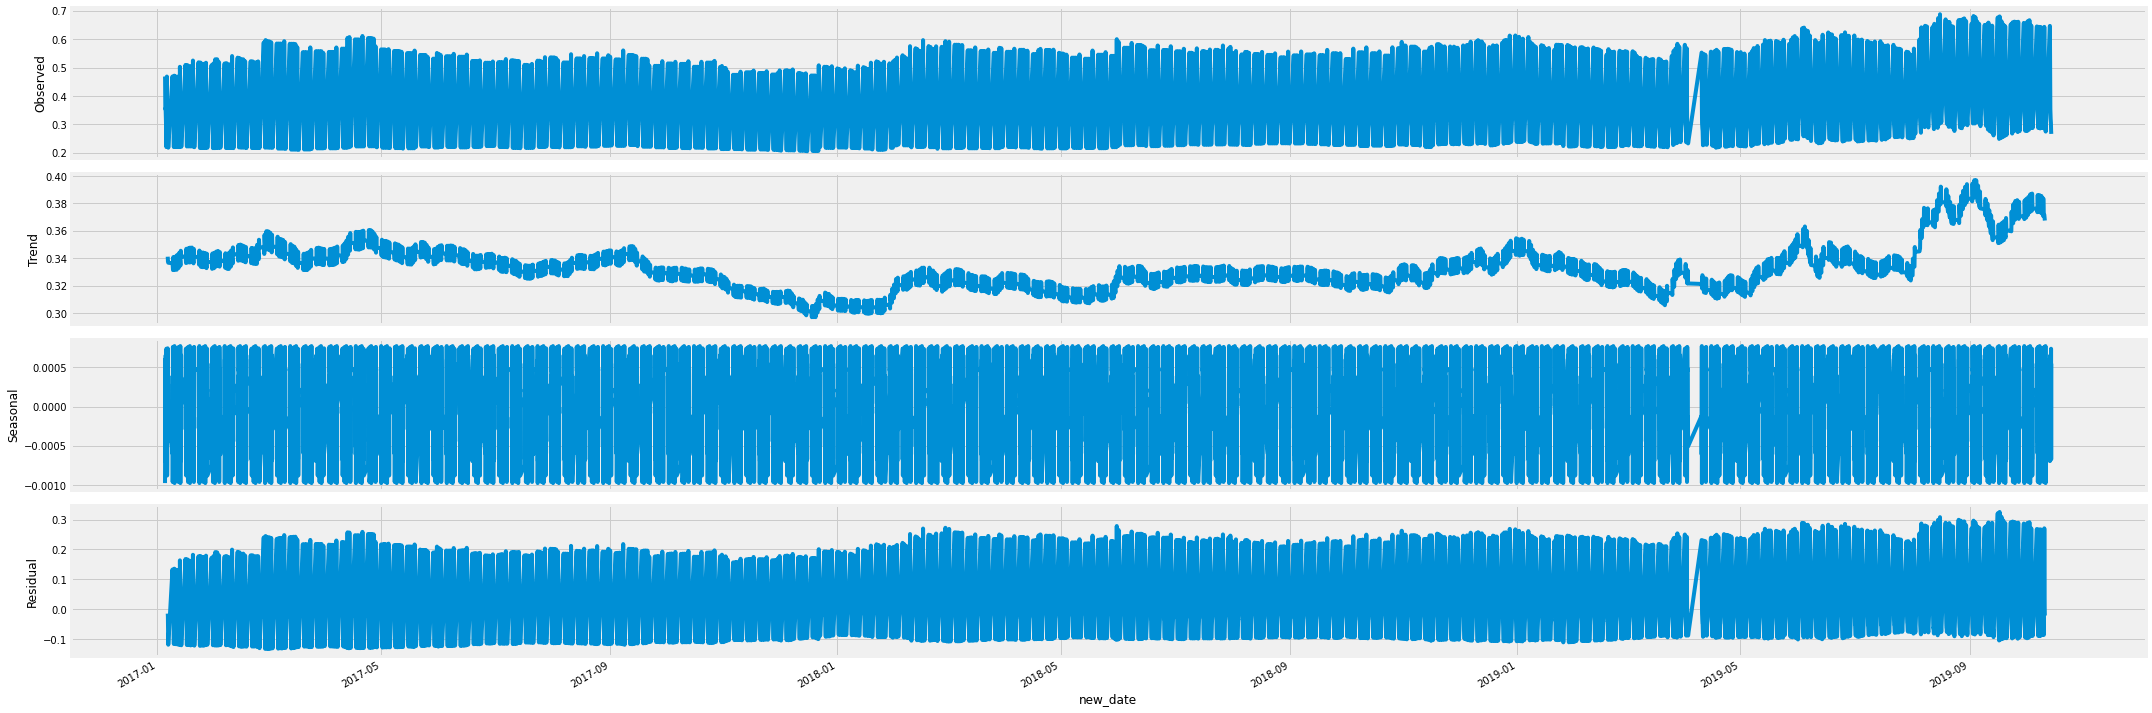

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 30,10
decomposed_volat_volume = sm.tsa.seasonal_decompose(train_df["0.1"],freq=60) # The frequncy is annual
figure = decomposed_volat_volume.plot()

plt.show()

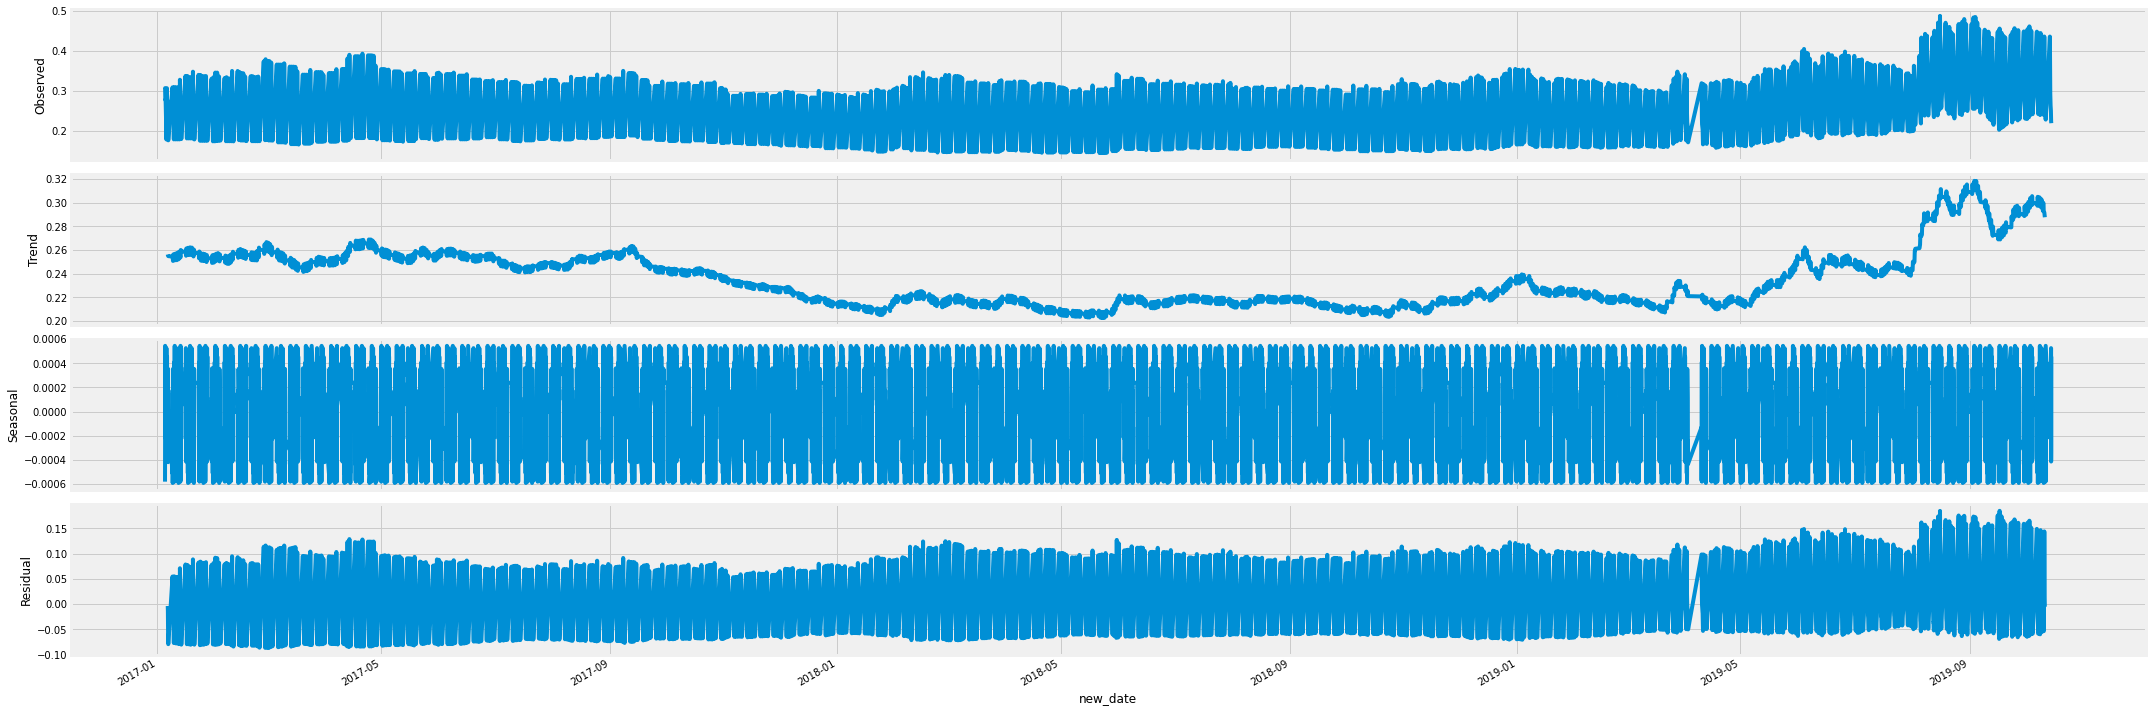

In [ ]:

decomposed_volat_volume = sm.tsa.seasonal_decompose(train_df["0.5"],freq=60) # The frequncy is annual
figure = decomposed_volat_volume.plot()

plt.show()

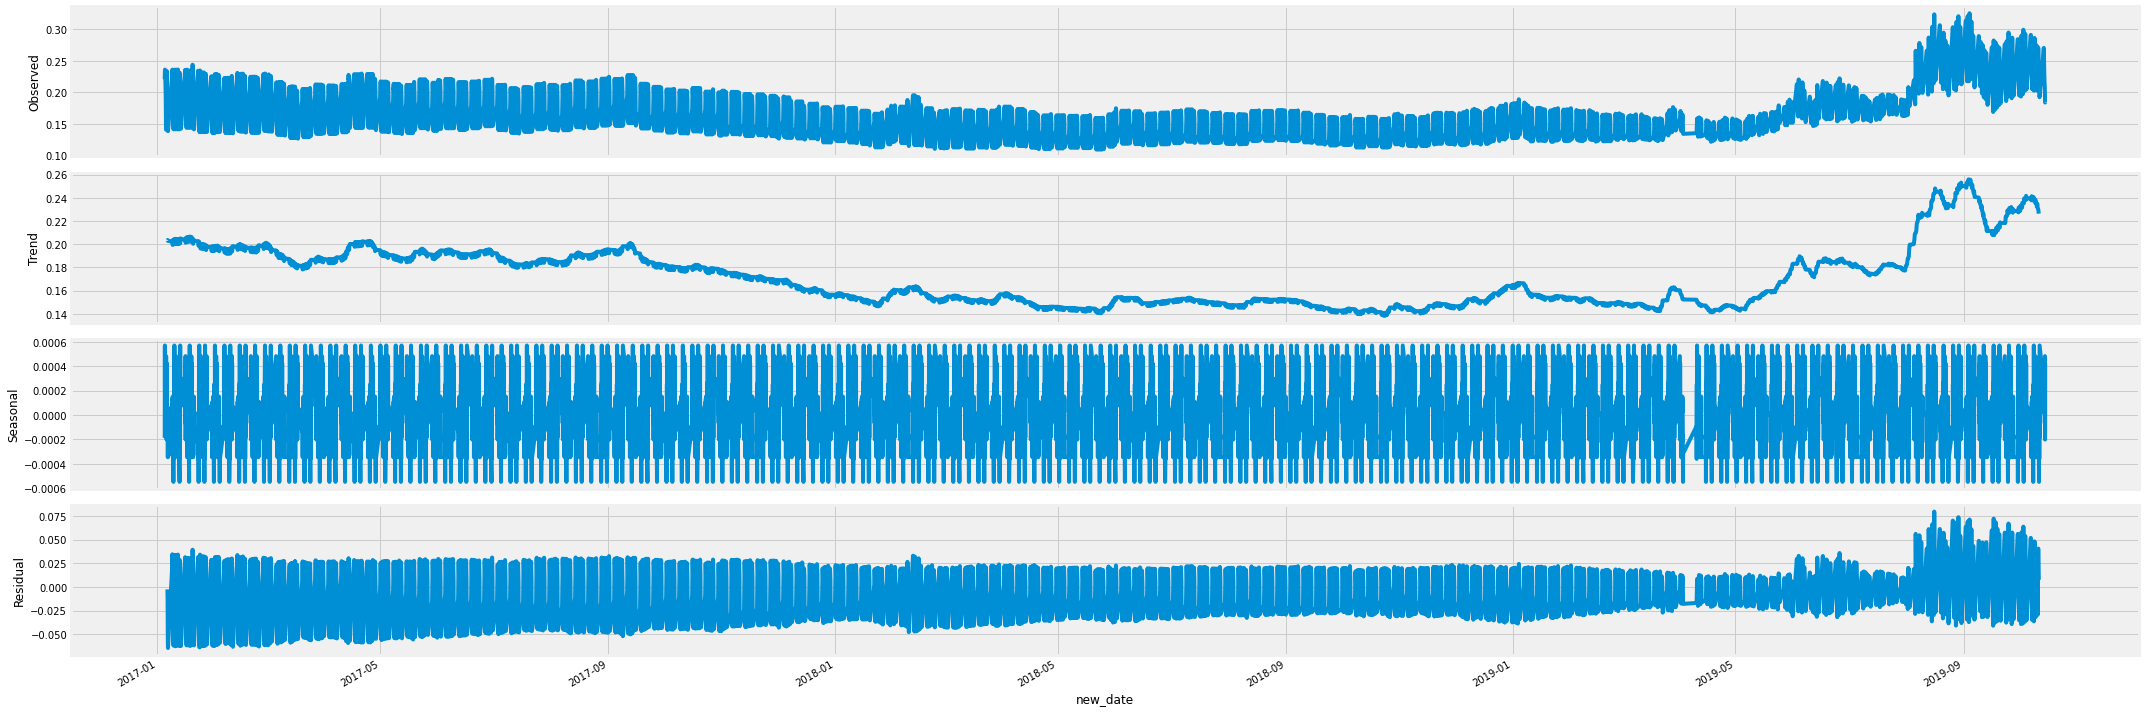

In [ ]:

decomposed_volat_volume = sm.tsa.seasonal_decompose(train_df["1"],freq=60) # The frequncy is annual
figure = decomposed_volat_volume.plot()

plt.show()

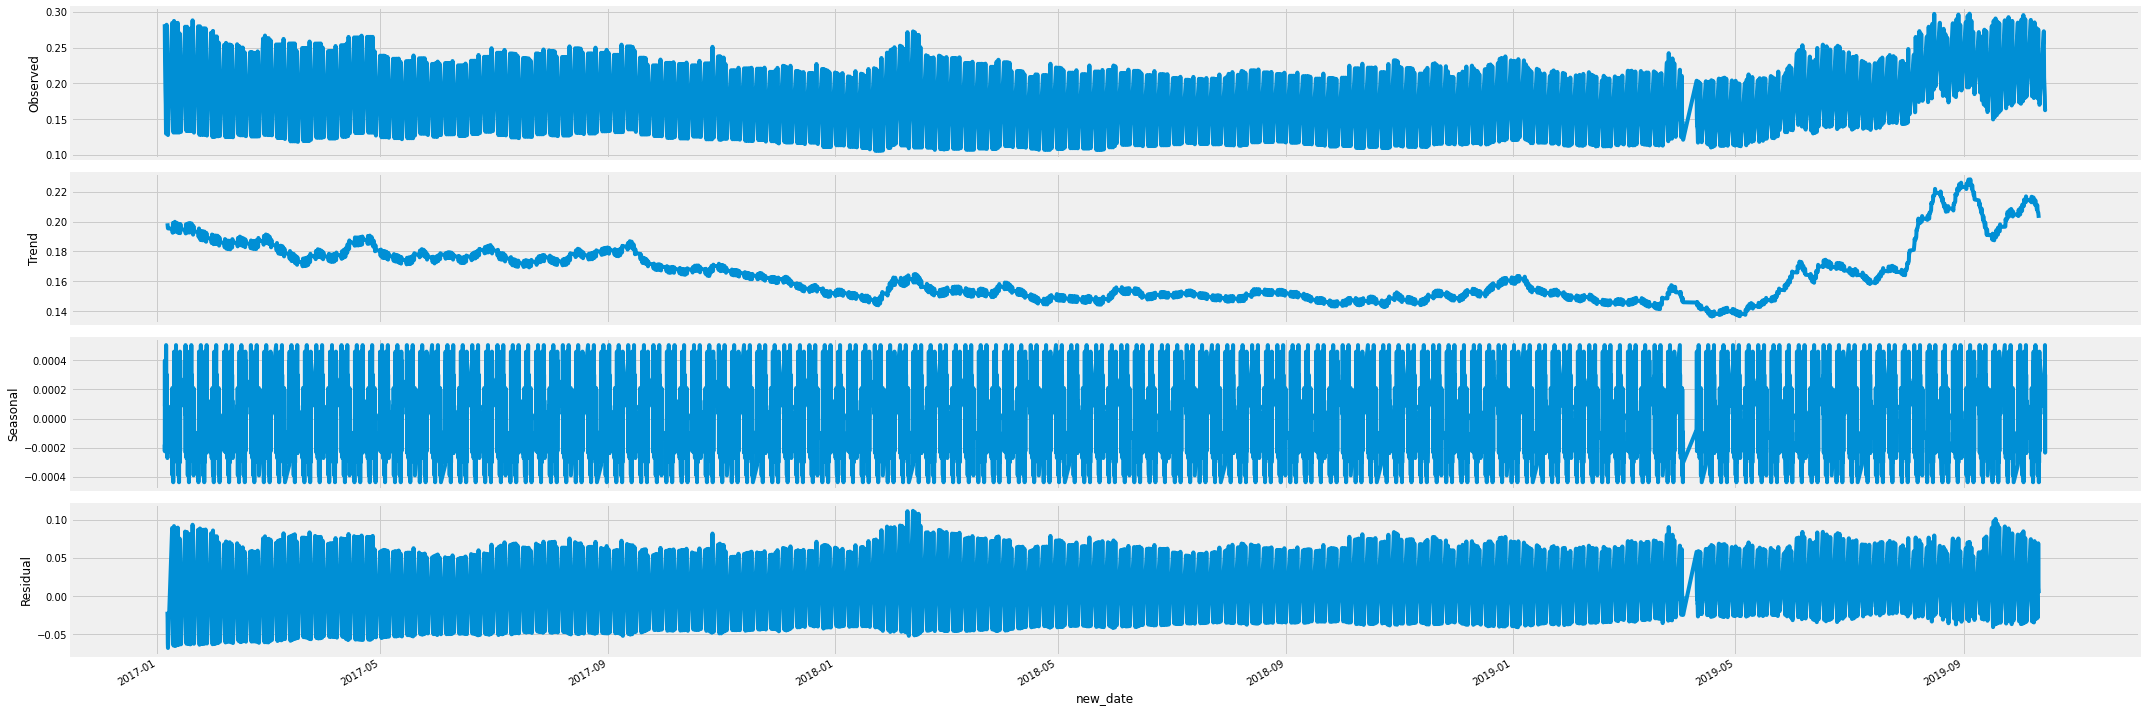

In [ ]:

decomposed_volat_volume = sm.tsa.seasonal_decompose(train_df["1.5"],freq=60) # The frequncy is annual
figure = decomposed_volat_volume.plot()

plt.show()

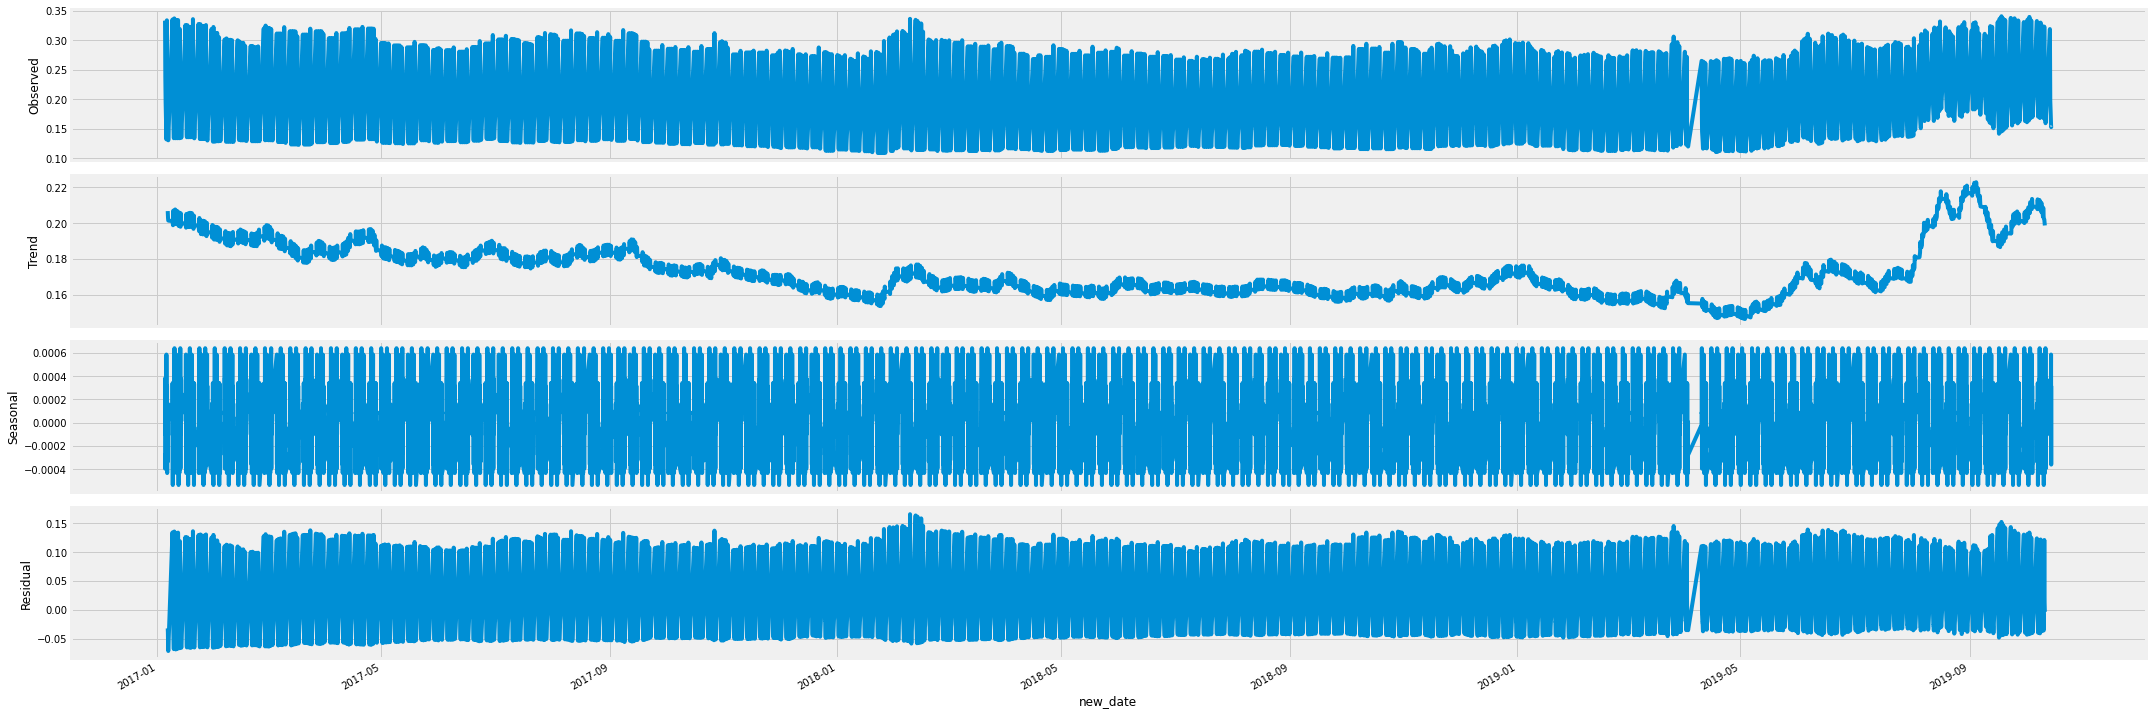

In [ ]:

decomposed_volat_volume = sm.tsa.seasonal_decompose(train_df["1.9"],freq=60) # The frequncy is annual
figure = decomposed_volat_volume.plot()

plt.show()

# MODELLING
* Time Series
* Traditional Machine Learning
* LSTM

## Time Series

ADF Test
H0: Series posses a unit root and henve is not stationary.

H1: Series is stationary

Test Statistics:
If p>0.05 accept H0

In [ ]:
from statsmodels.tsa.stattools import adfuller
columns = ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9',
       '1', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9',]
for i in columns:
    k=(train_df[i]**11)
    
    adf = adfuller(k.values, autolag='AIC')
    print("p-value of {}: {}".format(i,float(adf[1])))
    

p-value of 0.1: 0.027565605629523537
p-value of 0.2: 0.03400675125610285
p-value of 0.3: 0.02424820057377682
p-value of 0.4: 0.012026907974284778
p-value of 0.5: 0.0046475291075743965
p-value of 0.6: 0.0015268914303424171
p-value of 0.7: 0.00026429606715230815
p-value of 0.8: 7.448418545486034e-05
p-value of 0.9: 3.162121961088142e-05
p-value of 1: 3.1432655085526745e-05
p-value of 1.1: 3.5255278930597566e-05
p-value of 1.2: 4.3859080080784805e-05
p-value of 1.3: 9.213080241371912e-05
p-value of 1.4: 0.00017805206258890958
p-value of 1.5: 0.0002950206940187873
p-value of 1.6: 0.00017364046787191428
p-value of 1.7: 9.724040729986401e-05
p-value of 1.8: 6.720109552409079e-05
p-value of 1.9: 5.675200328107837e-05
